Item sales for the month immediately after the data in sales_train.csv, which is November 2015:

DAILY_SALES=pd.read_csv('sales_train.csv')
DAILY_SALES['date_dt']=pd.to_datetime(DAILY_SALES['date'],format="%d.%m.%Y")
print(DAILY_SALES.date_dt.max())
> Timestamp('2015-10-31 00:00:00')

You want to predict the total sales for that month, i.e. one number for each shop/item pair in the test.csv file.

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%precision 4
%reload_ext autoreload

import re
import sys
import math
import random
import datetime
import os

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
import warnings


warnings.filterwarnings(action='once')
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', -1)


import ktool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'%.4f'

ModuleNotFoundError: No module named 'ktool'

In [9]:
print(os.listdir("../input"))

['items.csv', 'item_categories.csv', 'sales_train.csv', 'sales_train.csv.gz', 'sample_submission.csv', 'sample_submission.csv.gz', 'shops.csv', 'test.csv', 'test.csv.gz']


In [5]:
items  = pd.read_csv('../input/items.csv')
train = pd.read_csv('../input/sales_train.csv')
test = pd.read_csv('../input/test.csv')
item_category = pd.read_csv('../input/item_categories.csv')
shops = pd.read_csv('../input/shops.csv')

In [6]:
train['date'].max()

'31.12.2014'

In [7]:
# -1 and 307980 looks like outliers, let's delete them
print('before train shape:', train.shape)
train = train[(train.item_price > 0) & (train.item_price < 300000)]
print('after train shape:', train.shape)

before train shape: (2935849, 6)
after train shape: (2935847, 6)


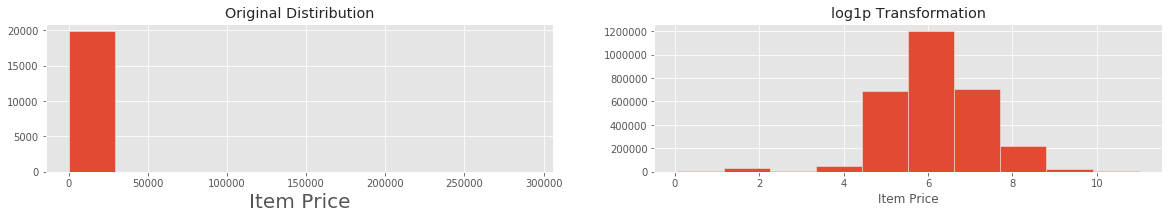

In [5]:

count_price = train.item_price.value_counts().sort_index(ascending=False)
plt.subplot(221)
count_price.hist(figsize=(20,6))
plt.xlabel('Item Price', fontsize=20);
plt.title('Original Distiribution')

plt.subplot(222)
train.item_price.map(np.log1p).hist(figsize=(20,6))
plt.xlabel('Item Price');
plt.title('log1p Transformation')
train.loc[:,'item_price'] = train.item_price.map(np.log1p)

Text(0.5,1,'Original Distiribution')

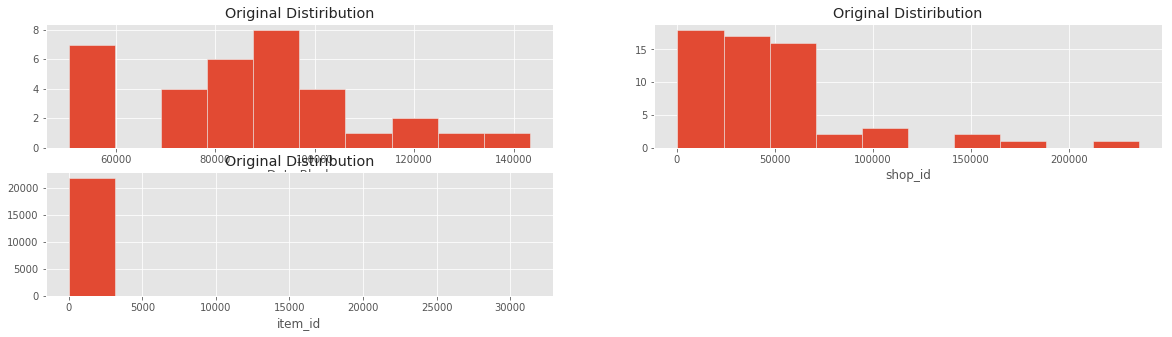

In [6]:
# unresanable_data(train['date_block_num'])
count_price = train.date_block_num.value_counts().sort_index(ascending=False)
plt.subplot(221)
count_price.hist(figsize=(20,5))
plt.xlabel('Date Block');
plt.title('Original Distiribution')

count_price = train.shop_id.value_counts().sort_index(ascending=False)
plt.subplot(222)
count_price.hist(figsize=(20,5))
plt.xlabel('shop_id');
plt.title('Original Distiribution')

count_price = train.item_id.value_counts().sort_index(ascending=False)
plt.subplot(223)
count_price.hist(figsize=(20,5))
plt.xlabel('item_id');
plt.title('Original Distiribution')



# Map the Items

In [7]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
item_to_cat_df = items.merge(item_category[['item_category_id','item_category_name']], how="inner", on="item_category_id").head()
item_to_cat_df.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [10]:
item_to_cat_df['cats']

KeyError: 'cats'

# Convert Date Column data type from object to Date 

In [11]:
train['date'] = pd.to_datetime(train.date,format="%d.%m.%Y")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,6.907755,1.0
1,2013-01-03,0,25,2552,6.802395,1.0
2,2013-01-05,0,25,2552,6.802395,-1.0
3,2013-01-06,0,25,2554,7.444278,1.0
4,2013-01-15,0,25,2555,7.003065,1.0


In [12]:
## Pivot by monht to wide format
p_df = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num    0     1    2    3    4  ...    29   30   31   32   33
shop_id item_id                           ...                          
0       30       0.0  31.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0
        31       0.0  11.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0
        32       6.0  10.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0
        33       3.0   3.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0
        35       1.0  14.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0

[5 rows x 34 columns]

In [13]:
## Join with categories
train_cleaned_df = p_df.reset_index()
train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")
train_cleaned_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name
0,54,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,Кино - DVD
1,54,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,***В ЛУЧАХ СЛАВЫ (UNV) D,40,Кино - DVD
2,54,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,***ГОЛУБАЯ ВОЛНА (Univ) D,40,Кино - DVD
3,54,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,***КОРОБКА (СТЕКЛО) D,40,Кино - DVD
4,54,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,40,Кино - DVD


In [14]:
train_cleaned_df['cats'] = train_cleaned_df.item_category_name

In [15]:
# Encode Categories
from sklearn import preprocessing

number = preprocessing.LabelEncoder()
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]
train_cleaned_df.head()

,shop_id,item_id,cats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,54,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,54,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Building

In [16]:
import xgboost as xgb
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

[13:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:26:14] /workspace/sr

In [17]:
xgb.plot_importance(bst)

ValueError: Booster.get_score() results in empty

In [18]:
apply_df = test
apply_df['shop_id']= apply_df.shop_id.astype('str')
apply_df['item_id']= apply_df.item_id.astype('str')

apply_df = test.merge(train_cleaned_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
apply_df.head()

,ID,shop_id,item_id,cats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
apply_df.head()

,ID,shop_id,item_id,cats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
preds = bst.predict(xgb.DMatrix(apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != 33)].values))

In [21]:
# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':apply_df.ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.028157
std,61834.358168,0.000000
min,0.000000,0.028157
25%,53549.750000,0.028157
50%,107099.500000,0.028157
75%,160649.250000,0.028157
max,214199.000000,0.028157


In [22]:
sub_df.to_csv('Submission_Predict Sales.csv',index=False)